In [1]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv
import pandas as pd
import os
import awkward as ak
import vector
import copy
import ROOT
plt.style.use('/eos/user/n/nchernya/MLHEP/AnomalyDetection/ADgvae/utils/adfigstyle.mplstyle')
import sys
sys.path.append(os.path.abspath(os.path.join('../')))
from plot_results import compute_profile


Welcome to JupyROOT 6.26/04


2022-07-05 21:06:10.113429: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-88592/x86_64-centos7-gcc8-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-35f7a/x86_64-centos7-gcc8-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/tensorflow/contrib/tensor_forest:/cvmfs/sft.c

In [2]:
files_dir = '/eos/user/n/nchernya/MLHEP/AnomalyDetection/knowledge-distillation/autoencoders/output/'
input_file = files_dir + 'l1_ae_train_loss.h5'


In [3]:
with h5py.File(input_file,'r') as open_file :
    train_data = np.array(open_file['data'])
idx_jet_0,idx_jet_1=9,19


In [4]:
events_with_jets_mask = np.where(train_data[:,idx_jet_0,0,0]!=0)

In [5]:
particles_in_jet = np.squeeze(train_data[events_with_jets_mask][:,idx_jet_0:,:,:],axis=-1)

In [6]:
jet_dir = 'JES_corrections/'
jet_pt_bins = [30,60,110,400]
jet_file_names = ['jets_eta_for_%dGeV_jets.csv'%jet_bin for jet_bin in jet_pt_bins]
jes_correction_data = {}
for i,jet_bin in enumerate(jet_pt_bins) :
    jes_correction_data[jet_bin] = pd.read_csv(jet_dir+jet_file_names[i], names=['eta','jet_response'])

#create_unique bin centers for all jet pt bins
bin_edges = np.linspace(0,4.8,49)
bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
for i,jet_bin in enumerate(jet_pt_bins) :
    jes_correction_data[jet_bin]['abs_eta_bin_centers'] = bin_centers
    
for i,jet_bin in enumerate(jet_pt_bins) :    
    jes_correction_data[jet_bin].to_csv(jet_dir+jet_file_names[i].replace('.csv','_updated.csv'))      
    

In [7]:
#create a multidimensional array from the dataframe
jes_correction_data_array = []
for i,jet_bin in enumerate(jet_pt_bins) :
    jes_correction_data_array.append(jes_correction_data[jet_bin][['abs_eta_bin_centers','jet_response']].values)
jes_correction_data_array = np.stack(jes_correction_data_array, axis=0)

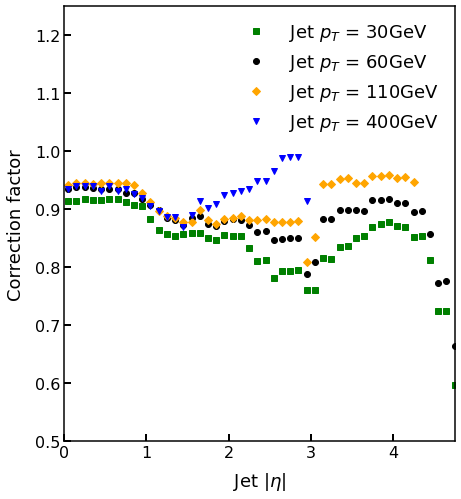

In [8]:
matplotlib.rcParams.update({'font.size': 18})
markers=['s', 'o', 'D', 'v']
colors=['g','black','orange','b']
for i,jet_bin in enumerate(jet_pt_bins) :
    _ = plt.plot(jes_correction_data[jet_bin]['abs_eta_bin_centers'],jes_correction_data[jet_bin]['jet_response'], label='Jet $p_T$ = %dGeV'%jet_bin,
                linestyle = 'None',
                marker=markers[i],
                color=colors[i])
plt.legend()
plt.ylabel('Correction factor')
plt.xlabel('Jet |$\eta$|')
plt.xlim(0, 4.75)
plt.ylim(0.5, 1.25)
plt.show()


In [9]:
def apply_correction(jes_correction_data_array,jet_pt_bins,sample,jet_pt_idx=0,jet_eta_idx=1):
    jet_eta_bins = jes_correction_data_array[0,:,0]
    
    indecies_pt = np.searchsorted(jet_pt_bins, abs(sample[:,:,jet_pt_idx]),side='left')
    indecies_pt = np.where(indecies_pt==len(jet_pt_bins),len(jet_pt_bins)-1,indecies_pt)

    indecies_eta = np.searchsorted(jet_eta_bins, abs(sample[:,:,jet_eta_idx]),side='left')
    indecies_eta = np.where(indecies_eta==len(jes_correction_data[jet_bin]['eta']),len(jes_correction_data[jet_bin]['eta'])-1,indecies_eta)
    
    return indecies_pt,indecies_eta


In [10]:
indecies_pt,indecies_eta = apply_correction(jes_correction_data_array,jet_pt_bins,particles_in_jet)
jet_pt_correction = jes_correction_data_array[indecies_pt,indecies_eta,1]

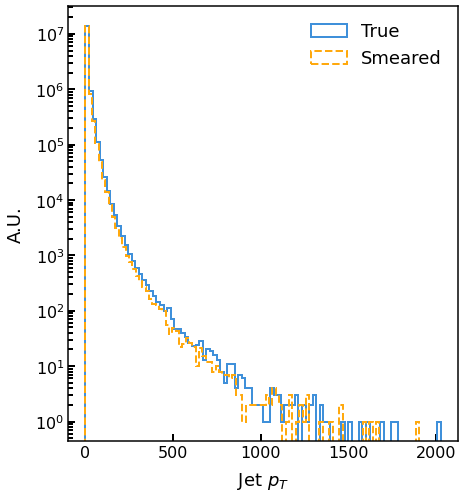

In [11]:
particles_in_jet_smeared = particles_in_jet[:,:,0]*jet_pt_correction
_ = plt.hist(particles_in_jet[:,:,0].reshape(-1),bins=100,histtype='step',linewidth=2,label='True')
_ = plt.hist(particles_in_jet_smeared.reshape(-1),bins=100,histtype='step',linestyle='--',linewidth=2,label='Smeared')
plt.semilogy()
plt.xlabel('Jet $p_T$')
plt.ylabel('A.U.')
plt.legend()


Text(0, 0.5, 'A.U.')

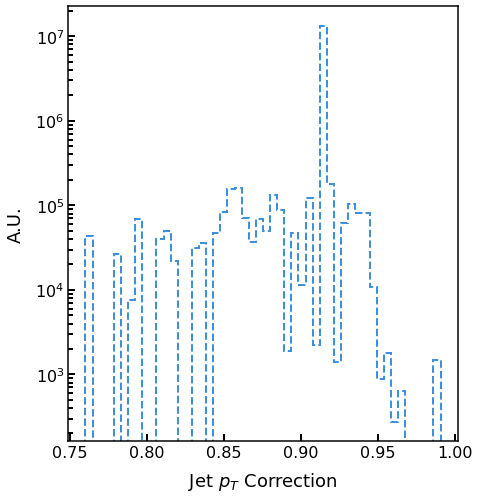

In [12]:
_ = plt.hist(jet_pt_correction.reshape(-1),bins=50,histtype='step',linestyle='--',linewidth=2,label='')
plt.semilogy()
plt.xlabel('Jet $p_T$ Correction')
plt.ylabel('A.U.')



In [13]:
jer_eta_bins = ['0p5','3p2_4']
jer_file_names = ['JER_eta_%s.csv'%jet_bin for jet_bin in jer_eta_bins]
jer_correction_data = {}
for i,jet_bin in enumerate(jer_eta_bins) :
    jer_correction_data[jet_bin] = pd.read_csv(jet_dir+jer_file_names[i], names=['pt','jer'])


In [14]:
def fit_function(x, a, b,c):
    return np.where(x!=0,np.sqrt(a/np.power(x,2)+b/x+c),0.)

do_fit = False
popts, pcovs = [],[]
for i,jet_bin in enumerate(jer_eta_bins) :
    if do_fit:
        popt, pcov = curve_fit(fit_function, xdata=jer_correction_data[jet_bin]['pt'], ydata=jer_correction_data[jet_bin]['jer'])
        popts.append(popt)
        pcovs.append(pcov)
        with open(jet_dir+'fit_result_'+jer_file_names[i].replace('.csv','.npy'), 'wb') as f:
            np.save(f, popts[i])
            np.save(f, pcovs[i])    
    else:    
        with open(jet_dir+'fit_result_'+jer_file_names[i].replace('.csv','.npy'), 'rb') as f:
            popt = np.load(f)
            pcov = np.load(f)   
            popts.append(popt)
            pcovs.append(pcov)


/tmp/nchernya/ipykernel_30094/3301358935.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0., 4000)


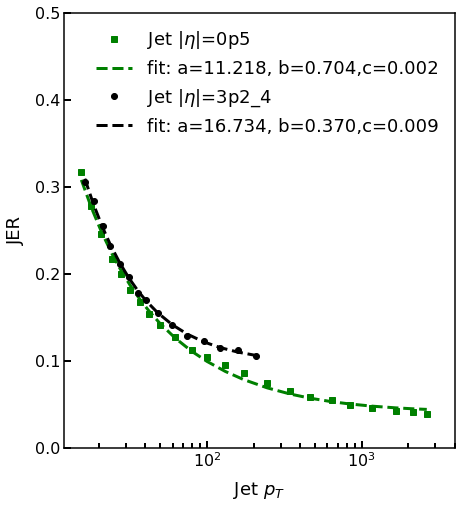

In [15]:
matplotlib.rcParams.update({'font.size': 18})
for i,jet_bin in enumerate(jer_eta_bins) :
    _ = plt.plot(jer_correction_data[jet_bin]['pt'],jer_correction_data[jet_bin]['jer'], label='Jet |$\eta$|=%s'%jet_bin,
                linestyle = 'None',marker=markers[i],color=colors[i])
    plt.plot(jer_correction_data[jet_bin]['pt'], fit_function(jer_correction_data[jet_bin]['pt'], *popts[i]),linewidth=3,
                      linestyle='--',color=colors[i],label='fit: a=%5.3f, b=%5.3f,c=%5.3f' % tuple(popts[i]))


plt.legend()
plt.ylabel('JER')
plt.xlabel('Jet $p_T$')
plt.semilogx()
plt.xlim(0., 4000)
plt.ylim(0., 0.5)
plt.show()

In [16]:
def get_jer(pt,eta,params,eta_bin=3.2):
    return np.where(eta<eta_bin,fit_function(pt, *params[0]),fit_function(pt, *params[1]))

In [17]:
jer_factor =  get_jer(particles_in_jet[:,:,0],particles_in_jet[:,:,1],popts)

/tmp/nchernya/ipykernel_30094/3722603696.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.where(x!=0,np.sqrt(a/np.power(x,2)+b/x+c),0.)


In [50]:
jet_pt_jes_jer_factor = jes_correction_data_array[indecies_pt,indecies_eta,1]* \
                        np.random.normal(1.0, scale=jer_factor*2, size=jet_pt_correction.shape) 
# #scale by 50% the resolution to mimnic L1(to go from PF)






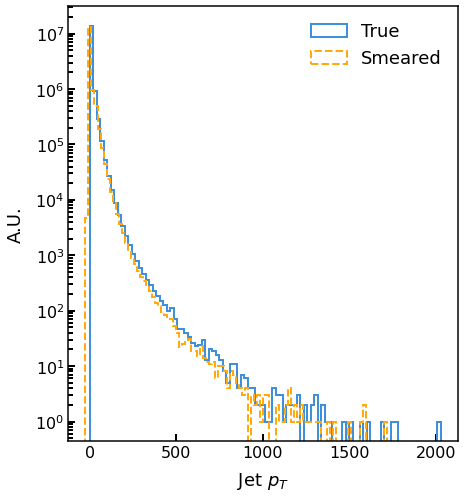

In [51]:
jet_pt_smeared = particles_in_jet[:,:,0]*jet_pt_jes_jer_factor
_ = plt.hist(particles_in_jet[:,:,0].reshape(-1),bins=100,histtype='step',linewidth=2,label='True')
_ = plt.hist(jet_pt_smeared.reshape(-1),bins=100,histtype='step',linestyle='--',linewidth=2,label='Smeared')
plt.semilogy()
plt.xlabel('Jet $p_T$')
plt.ylabel('A.U.')
plt.legend()

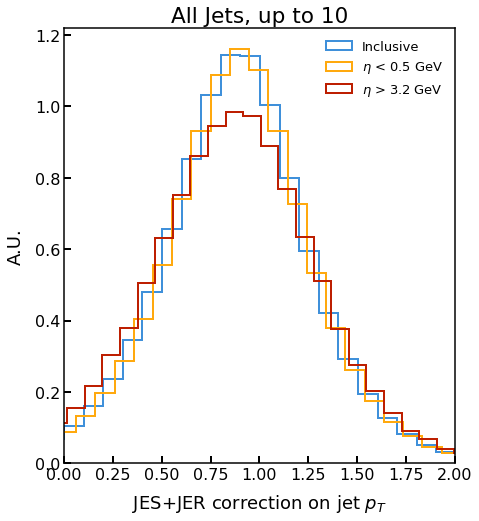

In [52]:
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where(particles_in_jet[:,:,0]>0)],bins=50,histtype='step',density=True,linewidth=2,label='Inclusive')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,1]<0.5)&(particles_in_jet[:,:,0]>0))],bins=50,histtype='step',density=True,linewidth=2,label='$\eta$ < 0.5 GeV')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,1]>3.2)&(particles_in_jet[:,:,0]>0))],bins=50,histtype='step',density=True,linewidth=2,label='$\eta$ > 3.2 GeV')
plt.title('All Jets, up to 10')
plt.xlim(0, 2)
plt.xlabel('JES+JER correction on jet $p_{T}$')
plt.ylabel('A.U.')
plt.legend(loc='upper right',fontsize=13)


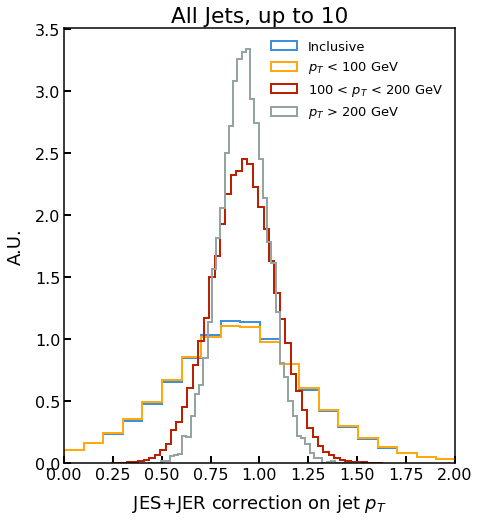

In [53]:
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where(particles_in_jet[:,:,0]>0)],bins=50,histtype='step',density=True,linewidth=2,label='Inclusive')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,0]<100)&(particles_in_jet[:,:,0]>0))],bins=50,histtype='step',density=True,linewidth=2,label='$p_{T}$ < 100 GeV')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where((particles_in_jet[:,:,0]>100) & (particles_in_jet[:,:,0]<200))],bins=50,histtype='step',density=True,linewidth=2,label='100 < $p_{T}$ < 200 GeV')
_ = plt.hist(jet_pt_jes_jer_factor[:,:][np.where(particles_in_jet[:,:,0]>200)],bins=50,histtype='step',density=True,linewidth=2,label='$p_{T}$ > 200 GeV')
plt.title('All Jets, up to 10')
plt.xlim(0, 2)
plt.xlabel('JES+JER correction on jet $p_{T}$')
plt.ylabel('A.U.')
plt.legend(loc='upper right',fontsize=13)

In [54]:
particles_in_jet_smeared = copy.deepcopy(particles_in_jet)
particles_in_jet_smeared[:,:,0]*=jet_pt_jes_jer_factor

In [55]:
#min true pt = 15 GeV for a jet, apply min pt cut of 20 GeV on smeared
pt_cut = np.where(particles_in_jet_smeared[:,:,0]!=0,particles_in_jet_smeared[:,:,0]>=20,True)
select_reco_jets = np.where(np.all(pt_cut,axis=1)==True)[0] #all jets in the event have smeared pt > 20 GeV

In [56]:
values, counts = np.unique(np.sum(particles_in_jet_smeared[:,:,0]!=0,axis=1), return_counts=True)

In [106]:
tot_evt = np.sum(counts)
for v,c in zip(values,counts):
    print("{} jets : ".format(v),"{} events, ".format(c),"fraction %.4f "%(c/tot_evt))
print()
for i,(v,c) in enumerate(zip(values,counts)):
    print(">={} jets : ".format(v),"{} events, ".format(np.sum(counts[i:])),"fraction %.4f "%(np.sum(counts[i:])/tot_evt))


1 jets :  1051841 events,  fraction 0.6978 
2 jets :  324801 events,  fraction 0.2155 
3 jets :  88409 events,  fraction 0.0587 
4 jets :  25349 events,  fraction 0.0168 
5 jets :  9270 events,  fraction 0.0062 
6 jets :  4164 events,  fraction 0.0028 
7 jets :  2040 events,  fraction 0.0014 
8 jets :  843 events,  fraction 0.0006 
9 jets :  365 events,  fraction 0.0002 
10 jets :  204 events,  fraction 0.0001 

>=1 jets :  1507286 events,  fraction 1.0000 
>=2 jets :  455445 events,  fraction 0.3022 
>=3 jets :  130644 events,  fraction 0.0867 
>=4 jets :  42235 events,  fraction 0.0280 
>=5 jets :  16886 events,  fraction 0.0112 
>=6 jets :  7616 events,  fraction 0.0051 
>=7 jets :  3452 events,  fraction 0.0023 
>=8 jets :  1412 events,  fraction 0.0009 
>=9 jets :  569 events,  fraction 0.0004 
>=10 jets :  204 events,  fraction 0.0001 


In [58]:
particles_in_jet_selected = particles_in_jet[select_reco_jets]
particles_in_jet_smeared_selected = particles_in_jet_smeared[select_reco_jets]

In [76]:
select_many_jets = np.where(np.sum(particles_in_jet_selected[:,:,0]!=0,axis=1)>=4)[0]
particles_in_jet_selected = particles_in_jet_selected[select_many_jets]
particles_in_jet_smeared_selected = particles_in_jet_smeared_selected[select_many_jets]

In [77]:
def create_lorentz_particles(particles):
    return vector.array({"pt":particles[:,:,0], 
                                        "eta":particles[:,:,1],
                                        "phi":particles[:,:,2],
                                        "M":np.zeros(particles[:,:,2].shape)})

def get_met_ht(lorentz_particles):
    met = np.sqrt(np.sum(lorentz_particles.px, axis=1)**2 +
              np.sum(lorentz_particles.py, axis=1)**2 +
              np.sum(lorentz_particles.pz, axis=1)**2)
    #ht = np.sum(lorentz_particles.pt, axis=1)
    ht = np.sqrt(np.sum(lorentz_particles.px**2+lorentz_particles.py**2+lorentz_particles.pz**2,axis=1))
    return met,ht

In [78]:
lorentz_particles_in_jet_smeared = create_lorentz_particles(particles_in_jet_smeared_selected)
lorentz_particles_in_jet = create_lorentz_particles(particles_in_jet_selected)

In [79]:
met_smeared,ht_smeared = get_met_ht(lorentz_particles_in_jet_smeared)
met,ht = get_met_ht(lorentz_particles_in_jet)


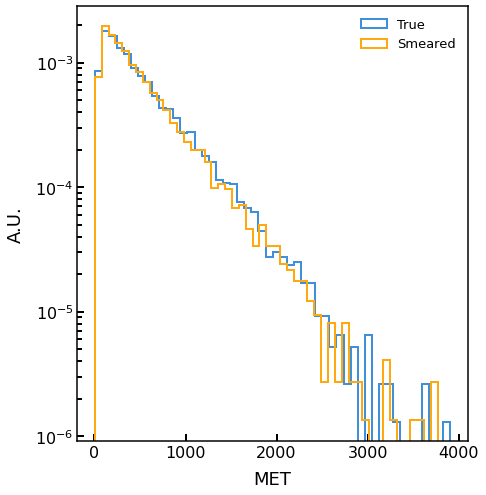

In [80]:
_ = plt.hist(met,bins=50,histtype='step',density=True,linewidth=2,label='True')
_ = plt.hist(met_smeared,bins=50,histtype='step',density=True,linewidth=2,label='Smeared')
plt.title('')
plt.xlabel('MET')
plt.ylabel('A.U.')
plt.semilogy()
plt.legend(loc='upper right',fontsize=13)

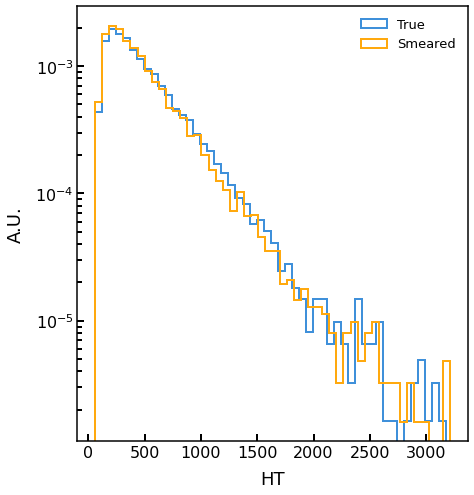

In [81]:
_ = plt.hist(ht,bins=50,histtype='step',density=True,linewidth=2,label='True')
_ = plt.hist(ht_smeared,bins=50,histtype='step',density=True,linewidth=2,label='Smeared')
plt.title('')
plt.xlabel('HT')
plt.ylabel('A.U.')
plt.semilogy()
plt.legend(loc='upper right',fontsize=13)

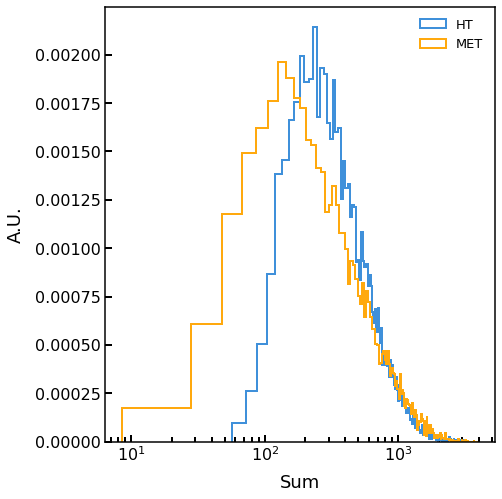

In [82]:
_ = plt.hist(ht,bins=200,histtype='step',density=True,linewidth=2,label='HT')
_ = plt.hist(met,bins=200,histtype='step',density=True,linewidth=2,label='MET')
plt.title('')
plt.xlabel('Sum')
plt.ylabel('A.U.')
plt.semilogx()
plt.legend(loc='upper right',fontsize=13)

[]

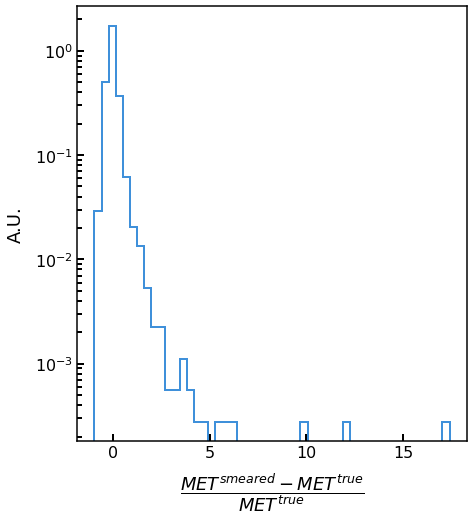

In [83]:
_ = plt.hist((met_smeared-met)/met,bins=50,histtype='step',density=True,linewidth=2)
plt.title('')
plt.xlabel(r'$\dfrac{MET^{smeared}-MET^{true}}{MET^{true}}$')
plt.ylabel('A.U.')
plt.semilogy()


Text(0, 0.5, 'A.U.')

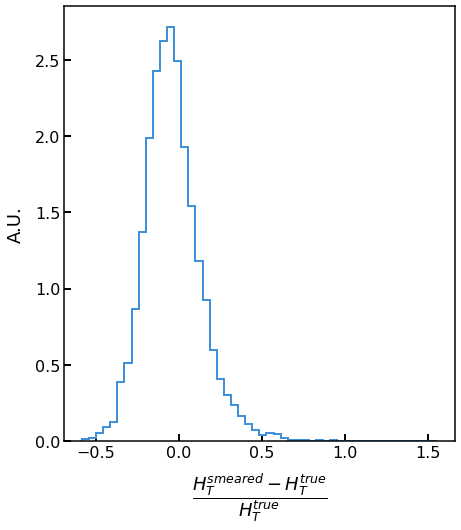

In [84]:
_ = plt.hist((ht_smeared-ht)/ht,bins=50,histtype='step',density=True,linewidth=2)
plt.title('')
#plt.xlim(-2,2)
plt.xlabel(r'$\dfrac{H_T^{smeared}-H_T^{true}}{H_T^{true}}$')
plt.ylabel('A.U.')
#plt.semilogy()

In [85]:
def plot_profile(x,y,x_title='',y_title='',nbins=20):
    p_x, p_mean, p_rms = compute_profile(x,y,nbins)
    plt.errorbar(p_x, p_mean, p_rms, fmt='_', ecolor='orange', color='blue')
    #plt.hist2d(x,y, 100, cmap='GnBu',
    #        norm=matplotlib.colors.LogNorm())
    #plt.colorbar()
    plt.xlabel(x_title)
    plt.ylabel(y_title)


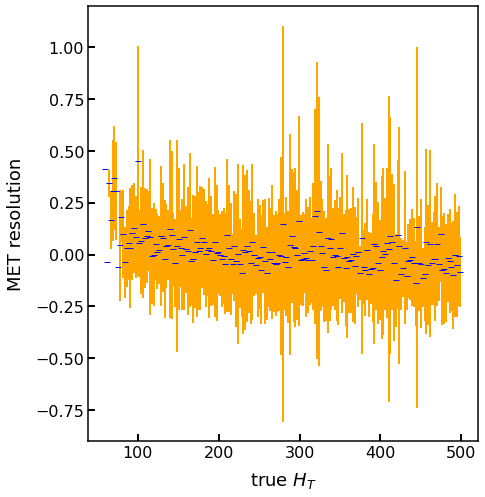

In [86]:
met_res = (met_smeared-met)/met
mask = ht<500
plot_profile(ht[mask],met_res[mask],x_title='true $H_T$',y_title='MET resolution',nbins=200)

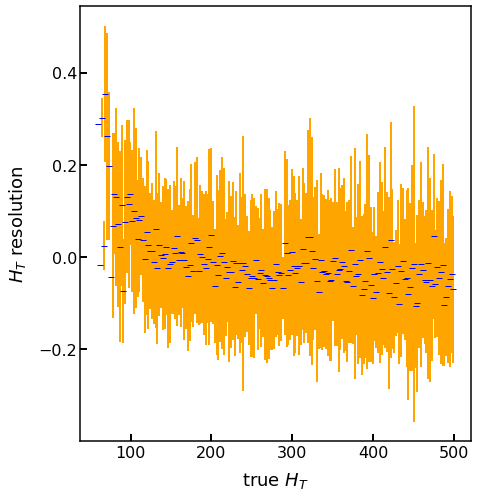

In [87]:
ht_res = (ht_smeared-ht)/ht
mask = ht<500
plot_profile(ht[mask],ht_res[mask],x_title='true $H_T$',y_title='$H_T$ resolution',nbins=200)

In [88]:
def makeEffHist(name, refArr, corrArr, corrThr, xmax,nbins=20, logxbins=None):
    not_matched = []
    if logxbins:
        nbins, nratio = int(logxbins[0]), float(logxbins[1])
        if nratio == 1:
            ret = ROOT.TEfficiency(name.replace(" ","_")+"_eff","",nbins,0,xmax)
        else:
            step = pow(nratio, 1.0/nbins)
            base = xmax*(step-1)/(nratio - 1)
            edges = [0]
            for i in xrange(nbins+1):
                edges.append(edges[-1] + base * pow(step, i))
            ret = ROOT.TEfficiency(name.replace(" ","_")+"_eff","",nbins,array('d',edges))
    else:
        ret = ROOT.TEfficiency(name+"_eff","",nbins,0,xmax)
        ret_nom = ROOT.TH1D(name+"_nom","",nbins,0,xmax)
        ret_denom = ROOT.TH1D(name+"_denom","",nbins,0,xmax)
    for i in range(0,len(refArr)):
        if corrArr[i]>corrThr :not_matched.append(i)
        ret.Fill(corrArr[i]>corrThr,refArr[i])
        ret_nom.Fill(corrArr[i],corrArr[i]>corrThr)
        ret_denom.Fill(refArr[i])
    ret_nom.Divide(ret_denom)
    ret.SetStatisticOption(ret.kFCP)
    return ret,not_matched,ret_nom

In [89]:
eff_met,_,_ = makeEffHist('name',met,met_smeared,120,420,nbins=40)
eff_ht,_,_ = makeEffHist('name',ht,ht_smeared,320,1400,nbins=40)

/tmp/nchernya/ipykernel_30094/1883009209.py:20: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  ret.Fill(corrArr[i]>corrThr,refArr[i])
Warning in <TROOT::Append>: Replacing existing TH1: name_nom (Potential memory leak).


In [90]:
def draw_eff(ret,legend,x_max,x_title):
    c1 = ROOT.TCanvas('c1', 'D', 10, 10, 700, 500 )
    frame = ROOT.TH1D("",legend, 100, 0, x_max)
    frame.Draw()
    frame.SetAxisRange(0,1.1,"Y");
    frame.SetYTitle("Efficiency")
    frame.SetXTitle(x_title)
    frame.SetStats(0)
    line = ROOT.TLine(0, 1, x_max, 1)
    line.SetLineStyle(2)
    line.Draw()
    ret.SetMarkerColor(ROOT.kRed)
    ret.Draw("same")
    c1.Draw() 
    c1.Update()
    return frame, line, c1

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


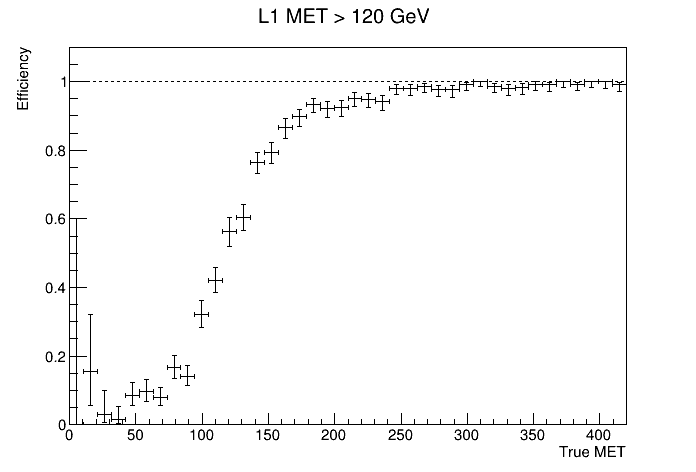

In [91]:
frame, line, c1 = draw_eff(eff_met,"L1 MET > 120 GeV",420,"True MET")
c1.Draw()
line.Draw()



Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


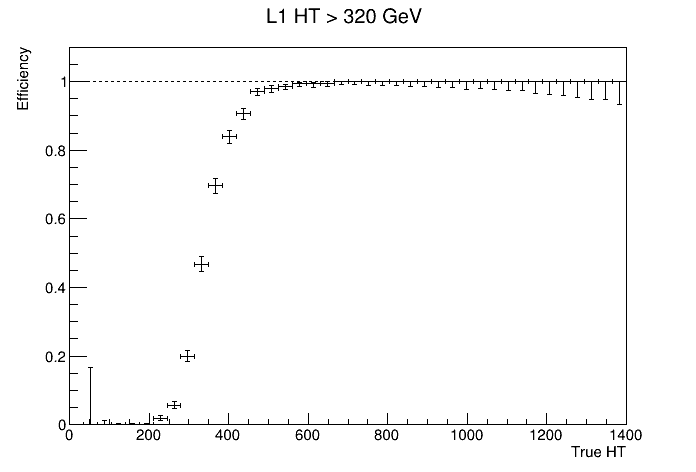

In [92]:
frame, line, c1 = draw_eff(eff_ht,"L1 HT > 320 GeV",1400,"True HT")
c1.Draw()
line.Draw()